# PercepTreeV1

Original code base: 
https://github.com/norlab-ulaval/PercepTreeV1

Tried and tested in jupyterlab (UGent, IDLab)

In [4]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 28.2 MB/s eta 0:00:00:00:0100:01


In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ifsqqf0c
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ifsqqf0c
  Resolved https://github.com/facebookresearch/detectron2.git to commit b7c7f4ba82192ff06f2bbb162b9f67b00ea55867
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.7/463.7 kB 8.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7

In [13]:
from __future__ import  absolute_import

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os, cv2
import torch

import matplotlib.pyplot as plt

# import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.video_visualizer import VideoVisualizer

[04/05 14:31:22 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/R-50_RGB_60k.pth ...


/opt/conda/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


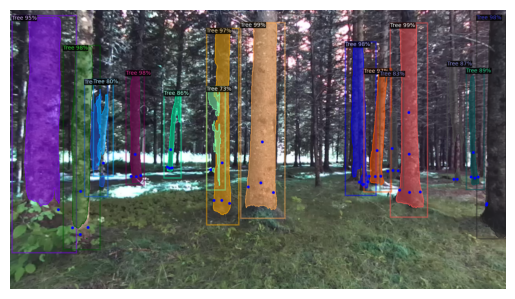

In [3]:
# local paths to model and image
# Download the model from the github repo https://github.com/norlab-ulaval/PercepTreeV1
# model_name = 'X-101_RGB_60k.pth'
model_name = 'R-50_RGB_60k.pth'
image_path = './output/image_00000_RGB.png'

if __name__ == "__main__":
    torch.cuda.is_available()
    logger = setup_logger(name=__name__)
    
    # All configurables are listed in /repos/detectron2/detectron2/config/defaults.py        
    cfg = get_cfg()
    cfg.INPUT.MASK_FORMAT = "bitmask"
    
    # Select your model here
    # cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"))
    # cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
    
    cfg.DATASETS.TRAIN = ()
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 8
    cfg.SOLVER.IMS_PER_BATCH = 8
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (tree)
    cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 1  
    cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 5
    cfg.MODEL.MASK_ON = True
    
    cfg.OUTPUT_DIR = './output'
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_name)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
    # cfg.INPUT.MIN_SIZE_TEST = 0  # no resize at test time
    
    # set detector
    predictor_synth = DefaultPredictor(cfg)    
    
    # set metadata
    tree_metadata = MetadataCatalog.get("my_tree_dataset").set(thing_classes=["Tree"], keypoint_names=["kpCP", "kpL", "kpR", "AX1", "AX2"])
    
    # inference
    im = cv2.imread(image_path)
    outputs_pred = predictor_synth(im)
    v_synth = Visualizer(im[:, :, ::-1],
                    metadata=tree_metadata, 
                    scale=1,
    )
    out_synth = v_synth.draw_instance_predictions(outputs_pred["instances"].to("cpu"))

    # Assuming out_synth.get_image() returns the image
    image = out_synth.get_image()[:, :, ::-1]  # Assuming the image is in BGR format, converting it to RGB
    
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()
    
    # cv2.imshow('predictions', out_synth.get_image()[:, :, ::-1])
    # k = cv2.waitKey(0)
    
    # cv2.destroyAllWindows()
    
        

[04/05 15:07:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/R-50_RGB_60k.pth ...


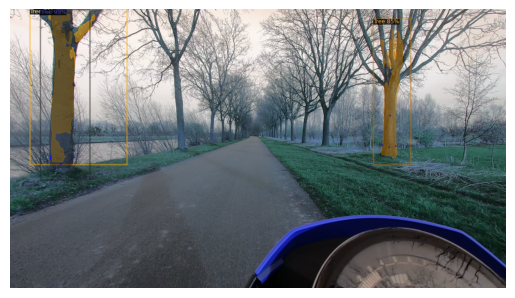

In [15]:
# local paths to model and image
# Download the model from the github repo https://github.com/norlab-ulaval/PercepTreeV1
# model_name = 'X-101_RGB_60k.pth'
model_name = 'R-50_RGB_60k.pth'
image_path = './output/eastbound_20240319_212.png'

if __name__ == "__main__":
    torch.cuda.is_available()
    logger = setup_logger(name=__name__)
    
    # All configurables are listed in /repos/detectron2/detectron2/config/defaults.py        
    cfg = get_cfg()
    cfg.INPUT.MASK_FORMAT = "bitmask"
    
    # Select your model here
    # cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"))
    # cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
    
    cfg.DATASETS.TRAIN = ()
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 8
    cfg.SOLVER.IMS_PER_BATCH = 8
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (tree)
    cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 1  
    cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 5
    cfg.MODEL.MASK_ON = True
    
    cfg.OUTPUT_DIR = './output'
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_name)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
    # cfg.INPUT.MIN_SIZE_TEST = 0  # no resize at test time
    
    # set detector
    predictor_synth = DefaultPredictor(cfg)    
    
    # set metadata
    tree_metadata = MetadataCatalog.get("my_tree_dataset").set(thing_classes=["Tree"], keypoint_names=["kpCP", "kpL", "kpR", "AX1", "AX2"])
        
    # inference
    im = cv2.imread(image_path)
    outputs_pred = predictor_synth(im)
    v_synth = Visualizer(im[:, :, ::-1],
                    metadata=tree_metadata, 
                    scale=1,
    )
    out_synth = v_synth.draw_instance_predictions(outputs_pred["instances"].to("cpu"))

    # Assuming out_synth.get_image() returns the image
    image = out_synth.get_image()[:, :, ::-1]  # Assuming the image is in BGR format, converting it to RGB
    
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()
    
    # cv2.imshow('predictions', out_synth.get_image()[:, :, ::-1])
    # k = cv2.waitKey(0)
    
    # cv2.destroyAllWindows()

In [18]:
dir(predictions)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_fields',
 '_image_size',
 'cat',
 'get',
 'get_fields',
 'has',
 'image_size',
 'remove',
 'set',
 'to']

Boxes:
- Zwart
- Geel (rechts)
- Geel (links)

Boxes:
- Linksboven(x,y), Rechtsonder(x,y)

y==0 => top van de afbeelding, y increases when you go down

In [40]:
predictions.get('pred_boxes')

Boxes(tensor([[ 165.7543,    3.9109,  436.3983,  931.9456],
        [1981.3906,   55.0251, 2185.4329,  849.8569],
        [ 109.2034,    0.0000,  637.5005,  847.5489]]))

Prediction keypoints (x,y,(z??)):
- felling cut (middelste punt onderaan)
- diameter left
- diameter right
- tree middle (in camera view)
- tree top (in camera view)

In [29]:
predictions.get('pred_keypoints')

tensor([[[2.7583e+02, 8.4380e+02, 8.5185e-02],
         [2.1928e+02, 8.1543e+02, 1.1611e-01],
         [3.3440e+02, 8.2151e+02, 6.7325e-02],
         [2.8593e+02, 5.5202e+02, 3.2399e-02],
         [2.9199e+02, 4.1828e+02, 1.2610e-02]],

        [[2.0672e+03, 7.5354e+02, 2.6416e-01],
         [2.0309e+03, 7.4138e+02, 1.9493e-01],
         [2.1016e+03, 7.4746e+02, 2.4563e-01],
         [2.0733e+03, 5.8120e+02, 7.6390e-02],
         [2.0834e+03, 4.0885e+02, 1.9948e-02]],

        [[2.7822e+02, 8.4451e+02, 3.0607e-01],
         [2.2154e+02, 8.0395e+02, 1.9154e-01],
         [3.3692e+02, 8.0801e+02, 1.1954e-01],
         [2.8834e+02, 4.9981e+02, 4.8919e-02],
         [3.0858e+02, 2.1391e+02, 1.9523e-02]]])

In [39]:
# Diameter in pixels for current frame (Gele boom rechts)

predictions.get('pred_keypoints')[0][2][0] - predictions.get('pred_keypoints')[0][1][0]

tensor(115.1247)

In [19]:
predictions.get_fields()

{'pred_boxes': Boxes(tensor([[ 165.7543,    3.9109,  436.3983,  931.9456],
         [1981.3906,   55.0251, 2185.4329,  849.8569],
         [ 109.2034,    0.0000,  637.5005,  847.5489]])),
 'scores': tensor([0.9860, 0.8484, 0.7167]),
 'pred_classes': tensor([0, 0, 0]),
 'pred_masks': tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],
 
         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False,

In [ ]:
# Code used for video data (we are probably not going to use this, instead we will use the above code for every frame)

#  model and video variables
model_name = 'R-50_RGB_60k.pth'
# model_name = 'X-101_RGB_60k.pth'
video_path = './output/forest_walk_1min.mp4'

if __name__ == "__main__":
    torch.cuda.is_available()
    logger = setup_logger(name=__name__)
    
    # All configurables are listed in /repos/detectron2/detectron2/config/defaults.py        
    cfg = get_cfg()
    cfg.INPUT.MASK_FORMAT = "bitmask"
    # cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"))
    # cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ()
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 8
    cfg.SOLVER.IMS_PER_BATCH = 8
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (tree)
    cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 1  
    cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 5
    cfg.MODEL.MASK_ON = True
    
    cfg.OUTPUT_DIR = './output' 
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_name)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
    # cfg.INPUT.MIN_SIZE_TEST = 0  # no resize at test time
    
    # set detector
    predictor_synth = DefaultPredictor(cfg)    
    
    # set metadata
    tree_metadata = MetadataCatalog.get("my_tree_dataset").set(thing_classes=["Tree"], keypoint_names=["kpCP", "kpL", "kpR", "AX1", "AX2"])
            
    # Get one video frame 
    vcap = cv2.VideoCapture(video_path)
    
    # get vcap property 
    w = int(vcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(vcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(vcap.get(cv2.CAP_PROP_FPS))
    n_frames = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # VIDEO recorder
    # Grab the stats from image1 to use for the resultant video
    # fourcc = cv2.VideoWriter_fourcc(*'mp4v')   
    # video = cv2.VideoWriter("pred_and_track_00.mp4",fourcc, 5, (w, h))  
    
    # Check if camera opened successfully
    if (vcap.isOpened()== False):
        print("Error opening video stream or file")
       
    vid_vis = VideoVisualizer(metadata=tree_metadata)
                                
    nframes = 0
    while(vcap.isOpened() ):
        ret, frame = vcap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        y = 000
        # h = 800
        x = 000
        # w = 800
        crop_frame = frame[y:y+h, x:x+w]
        # cv2.imshow('frame', crop_frame)
        if cv2.waitKey(1) == ord('q'):
                break
        
        # 5 fps
        if nframes % 12 == 0:
            outputs_pred = predictor_synth(crop_frame)s
            # v_synth = Visualizer(crop_frame[:, :, ::-1],
            #                     metadata=tree_metadata, 
            #                     scale=1, 
            #                     instance_mode =  ColorMode.IMAGE     # remove color from image, better see instances  
            #     )
            out = vid_vis.draw_instance_predictions(crop_frame, outputs_pred["instances"].to("cpu"))
                
            vid_frame = out.get_image()
            # video.write(vid_frame)
            # cv2.imshow('frame', vid_frame)

            # Assuming out_synth.get_image() returns the image
            image = out_synth.get_image()[:, :, ::-1]  # Assuming the image is in BGR format, converting it to RGB
            
            plt.imshow(vid_frame)
            plt.axis('off')  # Turn off axis
            plt.show()
            
        nframes += 1
    
    # video.release()
    vcap.release()
    # cv2.destroyAllWindows()